In [76]:
import LSBsteg

In [85]:
from scipy import fftpack
import numpy as np
from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing import image
import click
from PIL import Image

In [86]:
def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def dct_compress(img, rate=0.5):
    dct_size = img.shape[0]
    dct = int(dct_size*rate)
    image_dct = get_2D_dct(img)
    image_dct[dct:,dct:,...] = 0
    img_compressed = get_2d_idct(image_dct)
    return img_compressed

In [87]:
class Steganography(object):

    @staticmethod
    def __int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.
        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return ('{0:08b}'.format(r),
                '{0:08b}'.format(g),
                '{0:08b}'.format(b))

    @staticmethod
    def __bin_to_int(rgb):
        """Convert a binary (string) tuple to an integer tuple.
        :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :return: Return an int tuple (e.g. (220, 110, 96))
        """
        r, g, b = rgb
        return (int(r, 2),
                int(g, 2),
                int(b, 2))

    @staticmethod
    def __merge_rgb(rgb1, rgb2):
        """Merge two RGB tuples.
        :param rgb1: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :param rgb2: Another string tuple
        (e.g. ("00101010", "11101011", "00010110"))
        :return: An integer tuple with the two RGB values merged.
        """
        r1, g1, b1 = rgb1
        r2, g2, b2 = rgb2
        rgb = (r1[:4] + r2[:4],
               g1[:4] + g2[:4],
               b1[:4] + b2[:4])
        return rgb

    @staticmethod
    def merge(img1, img2):
        """Merge two images. The second one will be merged into the first one.
        :param img1: First image
        :param img2: Second image
        :return: A new merged image.
        """

        # Check the images dimensions
        if img2.size[0] > img1.size[0] or img2.size[1] > img1.size[1]:
            raise ValueError('Image 2 should not be larger than Image 1!')

        # Get the pixel map of the two images
        pixel_map1 = img1.load()
        pixel_map2 = img2.load()

        # Create a new image that will be outputted
        new_image = Image.new(img1.mode, img1.size)
        pixels_new = new_image.load()

        for i in range(img1.size[0]):
            for j in range(img1.size[1]):
                rgb1 = Steganography.__int_to_bin(pixel_map1[i, j])

                # Use a black pixel as default
                rgb2 = Steganography.__int_to_bin((0, 0, 0))

                # Check if the pixel map position is valid for the second image
                if i < img2.size[0] and j < img2.size[1]:
                    rgb2 = Steganography.__int_to_bin(pixel_map2[i, j])

                # Merge the two pixels and convert it to a integer tuple
                rgb = Steganography.__merge_rgb(rgb1, rgb2)

                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

        return new_image

    @staticmethod
    def unmerge(img):
        """Unmerge an image.
        :param img: The input image.
        :return: The unmerged/extracted image.
        """

        # Load the pixel map
        pixel_map = img.load()

        # Create the new image and load the pixel map
        new_image = Image.new(img.mode, img.size)
        pixels_new = new_image.load()

        # Tuple used to store the image original size
        original_size = img.size

        for i in range(img.size[0]):
            for j in range(img.size[1]):
                # Get the RGB (as a string tuple) from the current pixel
                r, g, b = Steganography.__int_to_bin(pixel_map[i, j])

                # Extract the last 4 bits (corresponding to the hidden image)
                # Concatenate 4 zero bits because we are working with 8 bit
                rgb = (r[4:] + '0000',
                       g[4:] + '0000',
                       b[4:] + '0000')

                # Convert it to an integer tuple
                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

                # If this is a 'valid' position, store it
                # as the last valid position
                if pixels_new[i, j] != (0, 0, 0):
                    original_size = (i + 1, j + 1)

        # Crop the image based on the 'valid' pixels
        new_image = new_image.crop((0, 0, original_size[0], original_size[1]))

        return new_image

In [5]:
def load_tiny_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [9]:
TINY_DATA_DIR = "data/tiny-imagenet-200"

TRAIN_DIR = os.path.join(TINY_DATA_DIR, "train")
TEST_DIR = os.path.join(TINY_DATA_DIR, "test")

DATA_DIR = "data/ensemble-data"
TINY_IMG_SHAPE = (64, 64)
IMG_SHAPE = (256, 256)

In [14]:
# Load dataset.
X_train_orig, X_test_orig = load_tiny_dataset_small(1,20)

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 200
Number of test examples = 20
X_train shape: (200, 64, 64, 3)


In [70]:
np.concatenate([img1,img2],axis=0).shape

(128, 64, 3)

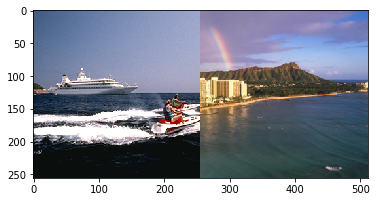

In [91]:
img1 = Image.open('data/coast/arnat59.jpg')
img2 = Image.open('data/coast/art294.jpg')
plt.imshow(np.concatenate([img1,img2],axis=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


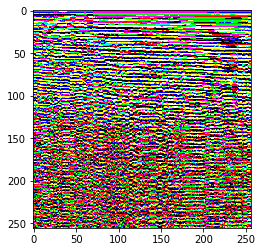

In [96]:
dct_array = get_2D_dct(np.asanyarray(img2))
plt.imshow(dct_array)

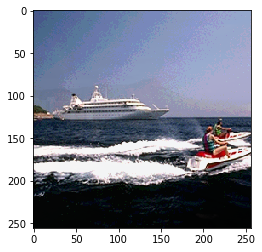

In [90]:
plt.imshow(merged)